# Prediction
Explanation:

## Import Packages

In [1]:
from importnb import Notebook
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import shap
from sklearn.calibration import calibration_curve
import seaborn as sns
import numpy as np

C:\Users\ssmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataframe import from 'FeatureEngineering'

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#with Notebook():
#    from ModelPreparation import data


## Manual Upload

In [ ]:
data = pd.read_csv('data.csv')

In [4]:
data

,ID,Number of Founders,Number of Employees,Number of Funding Rounds,Last Funding Amount,Total Funding Amount,Number of Lead Investors,Number of Investors,Number of Acquisitions,X: Followers,X: Following,X: Number of Tweets,X: Account Age Days,X: Tweet Activity,X: Followers Max Growth,X: Followers Max Loss,X: Tweets Max Growth,X: Tweets Max Loss,Months until First Round,Grant Y/N,Made Acquisitions,Project Funding,Startup Funding,Growth Funding,Expansion Funding,Exit Funding,Average Time To Next Round,Average Funding Size,Average Number of Investments by Investors,Average Number of Exits by Investors,Average Number of Lead Investments by Investors,Average Number of Portfolio Organizations by Investors,Investor Country_AUS,Investor Country_GER,Investor Country_SWI,Investor Country_UK,Investor Country_USA,Top Investor Participation,Industry_administrative services,Industry_advertising,Industry_agriculture and farming,Industry_apps,Industry_artificial intelligence (ai),Industry_biotechnology,Industry_blockchain and cryptocurrency,Industry_clothing and apparel,Industry_commerce and shopping,Industry_community and lifestyle,Industry_consumer electronics,Industry_consumer goods,Industry_content and publishing,Industry_data and analytics,Industry_design,Industry_education,Industry_energy,Industry_events,Industry_financial services,Industry_food and beverage,Industry_gaming,Industry_government and military,Industry_hardware,Industry_health care,Industry_information technology,Industry_internet services,Industry_lending and investments,Industry_manufacturing,Industry_media and entertainment,Industry_messaging and telecommunications,Industry_mobile,Industry_music and audio,Industry_natural resources,Industry_navigation and mapping,Industry_other,Industry_payments,Industry_platforms,Industry_privacy and security,Industry_professional services,Industry_real estate,Industry_sales and marketing,Industry_science and engineering,Industry_social impact,Industry_software,Industry_sports,Industry_sustainability,Industry_transportation,Industry_travel and tourism,Industry_video,LinkedIn: Average Followers Founders,LinkedIn: Average Connections Founders,LinkedIn: Min Followers Founders,LinkedIn: Max Followers Founders,LinkedIn: Min Connections Founders,LinkedIn: Max Connections Founders,Highest Education Bachelor,Highest Education Doctor/PhD,Highest Education Master,International Team,Top University,Studies Abroad Founder,Firsttime Founder Ratio,All Firsttime Founders,Any Firsttime Founder,Researcher Ratio,All Researchers,Any Researcher,Executive Ratio,All Executives,Any Executive,Few Years Experience Ratio,Decade Experience Ratio,Mid Career Experience Ratio,Avg Gaps in Experience,Avg Longest Position Duration,Success
0,1,1.0,30.5,2,7000000.0,7000000.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,40.0,0,0,1,1,0,0,0,31.550000,7000000.0,0.000000,182.0,220.000000,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4815.000000,3914.000000,4815.0,4815.0,3914.0,3914.0,0.0,0.0,1.0,0,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,150.166667,0
1,2,2.0,30.5,2,3000000.0,3000000.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,15.0,0,0,1,1,0,0,0,16.433333,3000000.0,321.000000,32.0,49.500000,277.0,0.0,1.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6482.000000,6479.000000,6482.0,6482.0,6479.0,6479.0,0.0,0.0,1.0,1,0.500000,0.50,0.000000,0.0,0.0,1.000000,1.0,1.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,7.000000,82.233333,0
2,3,2.0,30.5,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,29.0,0,0,1,1,0,0,0,29.400000,0.0,36.000000,7.0,19.000000,29.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.

## Train-Test-Split

In [5]:
# Splitting data into features and target
X = data.drop(columns=['Success'])
y = data['Success']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE on the training data, because of the imbalanced target variable (see above)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

## Models

### Logistic Regression

In [6]:
# Logistic Regression
warnings.filterwarnings("ignore", category=FutureWarning) # No influence on the result and just for a cleaner output
warnings.filterwarnings("ignore", category=UserWarning) # No influence on the result and just for a cleaner output
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_scaled, y_train_resampled)
logistic_predictions = logistic_model.predict(X_test_scaled)
logistic_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]
logistic_auc = roc_auc_score(y_test, logistic_proba)
logistic_report = classification_report(y_test, logistic_predictions, output_dict=True)

print('Test AUC:', logistic_auc)
print('Classification Report:')
print(classification_report(y_test, logistic_predictions))

Test AUC: 0.7926043797832842
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       249
           1       0.42      0.70      0.52        53

    accuracy                           0.77       302
   macro avg       0.67      0.74      0.69       302
weighted avg       0.84      0.77      0.79       302



### Gradient Boosting

In [26]:
# Gradient Boosting
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.03, 0.035],  
    'n_estimators': [400, 450],  
    'max_depth': [5, 6],  
    'min_samples_split': [8, 10],  
    'min_samples_leaf': [6, 7],  
    'subsample': [0.6, 0.7],  
    'max_features': ['sqrt', 'log2'],  
}

# Initialize the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Define the scoring metric
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=10,  # Stratified K-Fold Cross-Validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV to the data
grid_search.fit(X_train_scaled, y_train_resampled)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)

# Evaluate the best model on the test set
best_gb_model = grid_search.best_estimator_
test_predictions = best_gb_model.predict(X_test_scaled)
test_auc = roc_auc_score(y_test, best_gb_model.predict_proba(X_test_scaled)[:, 1])

print("Test AUC Score:", test_auc)
print("Classification Report on Test Set:")
print(classification_report(y_test, test_predictions))

Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best Parameters: {'learning_rate': 0.03, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 400, 'subsample': 0.6}
Test AUC Score: 0.8500416761385163
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       249
           1       0.79      0.57      0.66        53

    accuracy                           0.90       302
   macro avg       0.85      0.77      0.80       302
weighted avg       0.89      0.90      0.89       302



### LightGBM

In [31]:
# LightGBM
# Define the hyperparameter grid for LightGBM
param_grid_lgb = {
    'learning_rate': [0.02, 0.025],          
    'n_estimators': [300, 350],             
    'min_child_samples': [4, 6, 8],        
    'num_leaves': [15, 20],                 
    'subsample': [0.5, 0.55],               
    'colsample_bytree': [0.6],             
    'reg_alpha': [0.5, 1.0],                
    'reg_lambda': [3.0],                   
    'scale_pos_weight': [1.0, 1.5, 2.0],    
}
# Initialize the LightGBM Classifier
lgb_model = LGBMClassifier(random_state=42)

# Set up GridSearchCV for LightGBM
grid_search_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid_lgb,
    scoring=scorer,  # Use AUC as the scoring metric
    cv=5,  
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV to the data
grid_search_lgb.fit(X_train_scaled, y_train_resampled)

# Get the best parameters and score for LightGBM
best_params_lgb = grid_search_lgb.best_params_
best_score_lgb = grid_search_lgb.best_score_

print("Best Parameters (LightGBM):", best_params_lgb)

# Evaluate the best LightGBM model on the test set
best_lgb_model = grid_search_lgb.best_estimator_
lgb_predictions = best_lgb_model.predict(X_test_scaled)
lgb_proba = best_lgb_model.predict_proba(X_test_scaled)[:, 1]
lgb_test_auc = roc_auc_score(y_test, lgb_proba)

print("Test AUC Score (LightGBM):", lgb_test_auc)
print("Classification Report (LightGBM):\n", classification_report(y_test, lgb_predictions))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[LightGBM] [Info] Number of positive: 997, number of negative: 997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13323
[LightGBM] [Info] Number of data points in the train set: 1994, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Parameters (LightGBM): {'colsample_bytree': 0.6, 'learning_rate': 0.02, 'min_child_samples': 4, 'n_estimators': 300, 'num_leaves': 15, 'reg_alpha': 0.5, 'reg_lambda': 3.0, 'scale_pos_weight': 1.0, 'subsample': 0.5}
Test AUC Score (LightGBM): 0.8465560354626052
Classification Report (LightGBM):
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       249
           1       0.78      0.58      0.67        53

    accuracy                       

### Neural Network

In [32]:
# Neural Network
nn_model = Sequential([
    Dense(256, kernel_regularizer=regularizers.l2(0.01), input_dim=X_train_scaled.shape[1], kernel_initializer=HeNormal(seed=42)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.1),

    Dense(128, kernel_regularizer=regularizers.l2(0.01), kernel_initializer=HeNormal(seed=42)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.1),

    Dense(64, kernel_regularizer=regularizers.l2(0.01), kernel_initializer=HeNormal(seed=42)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.1),

    Dense(32, kernel_regularizer=regularizers.l2(0.01), kernel_initializer=HeNormal(seed=42)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation='sigmoid', kernel_initializer=HeNormal(seed=42))
])

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Train the model with class weights
class_weights = {0: 1.0, 1: 3.0}  
nn_model.fit(X_train_scaled, y_train_resampled, epochs=100, batch_size=32, verbose=0, shuffle=False, class_weight=class_weights)

# Predictions with optimized threshold
y_probs = nn_model.predict(X_test_scaled).flatten()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

nn_predictions = (y_probs > optimal_threshold).astype(int)
nn_report = classification_report(y_test, nn_predictions, output_dict=True)

# Evaluation
print("Optimal Threshold:", optimal_threshold)
print("Test AUC Score (Neural Network):", roc_auc_score(y_test, y_probs))
print("Classification Report (Neural Network):\n", classification_report(y_test, nn_predictions))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Optimal Threshold: 0.6561148
Test AUC Score (Neural Network): 0.7514586648480716
Classification Report (Neural Network):
               precision    recall  f1-score   support

           0       0.89      0.90      0.90       249
           1       0.51      0.49      0.50        53

    accuracy                           0.83       302
   macro avg       0.70      0.70      0.70       302
weighted avg       0.83      0.83      0.83       302



### Weighted Ensemble

In [40]:
# Weighted Ensemble 
ensemble_proba_weighted = (
    0.35 * best_gb_model.predict_proba(X_test_scaled)[:, 1] +
    0.35 * best_lgb_model.predict_proba(X_test_scaled)[:, 1] +
    0.3 * nn_model.predict(X_test_scaled).flatten() +
    0.0 * logistic_model.predict_proba(X_test_scaled)[:, 1]
)

# Optimize Threshold for Weighted Ensemble
precision, recall, thresholds = precision_recall_curve(y_test, ensemble_proba_weighted)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]

ensemble_predictions_weighted = (ensemble_proba_weighted > optimal_threshold).astype(int)

# Evaluation des Weighted Ensembles
ensemble_auc_weighted = roc_auc_score(y_test, ensemble_proba_weighted)
ensemble_report_weighted = classification_report(y_test, ensemble_predictions_weighted)

print("Optimized Weighted Ensemble Test AUC Score:", ensemble_auc_weighted)
print("Optimal Threshold for Weighted Ensemble:", optimal_threshold)
print("Classification Report (Optimized Weighted Ensemble):\n", ensemble_report_weighted)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Optimized Weighted Ensemble Test AUC Score: 0.8648177616124877
Optimal Threshold for Weighted Ensemble: 0.5528418995718338
Classification Report (Optimized Weighted Ensemble):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       249
           1       0.81      0.57      0.67        53

    accuracy                           0.90       302
   macro avg       0.86      0.77      0.80       302
weighted avg       0.90      0.90      0.89       302



### Results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
                 Model  Accuracy  Precision  Recall  F1-Score    AUC
0    Gradient Boosting    0.8974     0.8512  0.7670    0.7995 0.8500
1             LightGBM    0.8974     0.8455  0.7744    0.8030 0.8466
2       Neural Network    0.8278     0.7011  0.6951    0.6980 0.7515
3  Logistic Regression    0.7748     0.6703  0.7446    0.6870 0.7926
4    Weighted Ensemble    0.9007     0.8620  0.7690    0.8042 0.8648
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


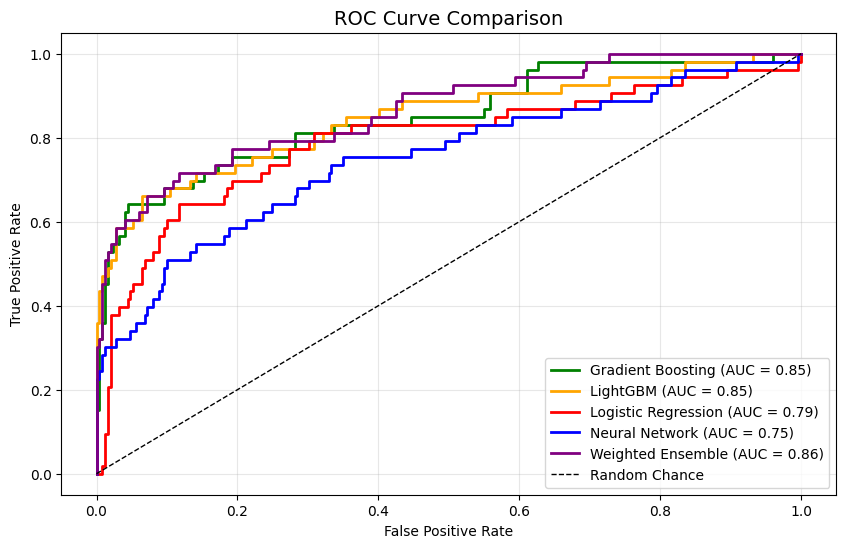

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


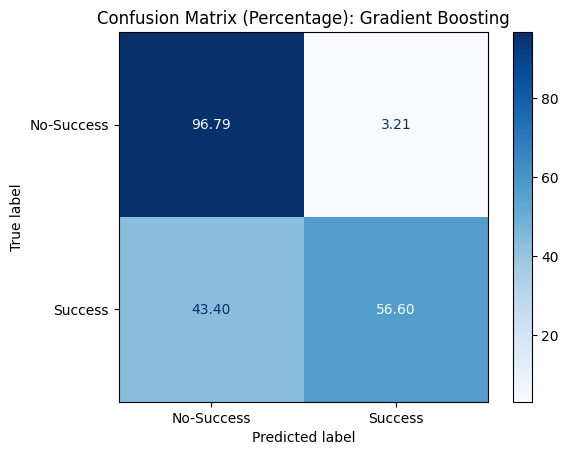

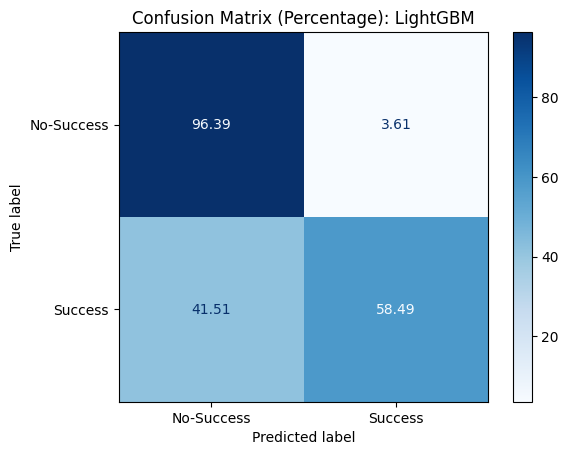

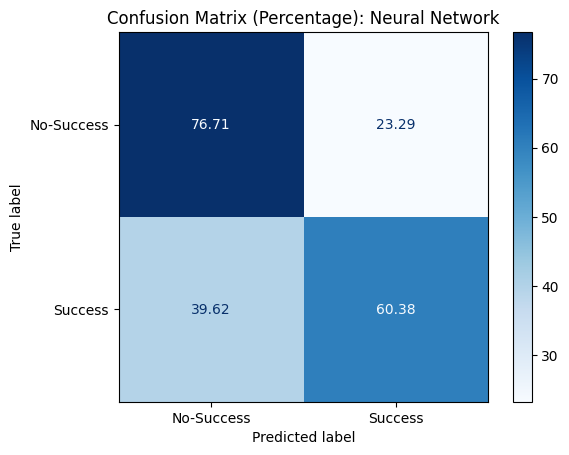

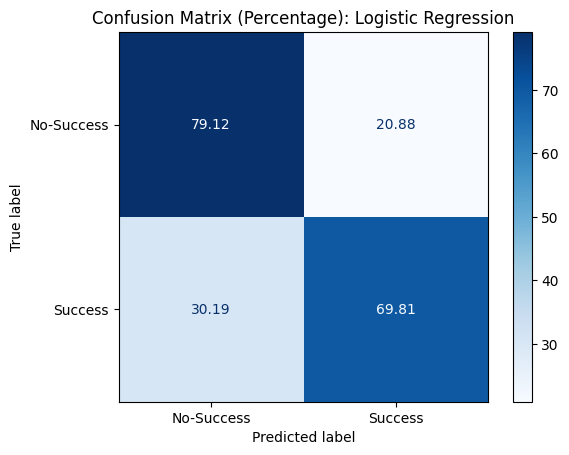

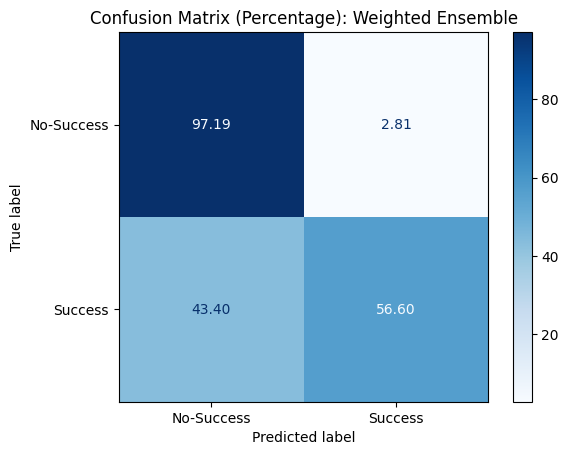

In [41]:
### Results
# Results Comparison
results = {
    "Model": ["Gradient Boosting", "LightGBM", "Neural Network", "Logistic Regression", "Weighted Ensemble"],
    "Accuracy": [
        classification_report(y_test, best_gb_model.predict(X_test_scaled), output_dict=True)['accuracy'],
        classification_report(y_test, best_lgb_model.predict(X_test_scaled), output_dict=True)['accuracy'],
        nn_report['accuracy'],
        logistic_report['accuracy'],
        classification_report(y_test, ensemble_predictions_weighted, output_dict=True)['accuracy']
    ],
    "Precision": [
        classification_report(y_test, best_gb_model.predict(X_test_scaled), output_dict=True)['macro avg']['precision'],
        classification_report(y_test, best_lgb_model.predict(X_test_scaled), output_dict=True)['macro avg']['precision'],
        nn_report['macro avg']['precision'],
        logistic_report['macro avg']['precision'],
        classification_report(y_test, ensemble_predictions_weighted, output_dict=True)['macro avg']['precision']
    ],
    "Recall": [
        classification_report(y_test, best_gb_model.predict(X_test_scaled), output_dict=True)['macro avg']['recall'],
        classification_report(y_test, best_lgb_model.predict(X_test_scaled), output_dict=True)['macro avg']['recall'],
        nn_report['macro avg']['recall'],
        logistic_report['macro avg']['recall'],
        classification_report(y_test, ensemble_predictions_weighted, output_dict=True)['macro avg']['recall']
    ],
    "F1-Score": [
        classification_report(y_test, best_gb_model.predict(X_test_scaled), output_dict=True)['macro avg']['f1-score'],
        classification_report(y_test, best_lgb_model.predict(X_test_scaled), output_dict=True)['macro avg']['f1-score'],
        nn_report['macro avg']['f1-score'],
        logistic_report['macro avg']['f1-score'],
        classification_report(y_test, ensemble_predictions_weighted, output_dict=True)['macro avg']['f1-score']
    ],
    "AUC": [
        roc_auc_score(y_test, best_gb_model.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, best_lgb_model.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, nn_model.predict(X_test_scaled).ravel()),
        logistic_auc,
        roc_auc_score(y_test, ensemble_proba_weighted)
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

# Plotting ROC Curve
plt.figure(figsize=(10, 6))
for model, name, color in zip([best_gb_model, best_lgb_model, logistic_model],
                              ["Gradient Boosting", "LightGBM", "Logistic Regression"],
                              ["green", "orange", "red"]):
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})', linewidth=2, color=color)

# Add Neural Network to ROC Curve
nn_pred_proba = nn_model.predict(X_test_scaled).ravel()
fpr, tpr, _ = roc_curve(y_test, nn_pred_proba)
auc = roc_auc_score(y_test, nn_pred_proba)
plt.plot(fpr, tpr, label=f'Neural Network (AUC = {auc:.2f})', linewidth=2, color='blue')

# Add Weighted Ensemble to ROC Curve
fpr, tpr, _ = roc_curve(y_test, ensemble_proba_weighted)
auc = roc_auc_score(y_test, ensemble_proba_weighted)
plt.plot(fpr, tpr, label=f'Weighted Ensemble (AUC = {auc:.2f})', linewidth=2, color='purple')

# Add Baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Predictions
models = [
    ("Gradient Boosting", best_gb_model, best_gb_model.predict(X_test_scaled)),
    ("LightGBM", best_lgb_model, best_lgb_model.predict(X_test_scaled)),
    ("Neural Network", nn_model, (nn_model.predict(X_test_scaled) > optimal_threshold).astype(int)),
    ("Logistic Regression", logistic_model, logistic_predictions),
    ("Weighted Ensemble", None, ensemble_predictions_weighted)  # None for model since it's a manual ensemble
]

for name, model, predictions in models:
    # Calculate confusion matrix and normalize to percentage
    cm = confusion_matrix(y_test, predictions)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Display confusion matrix
    cmd = ConfusionMatrixDisplay(cm_percentage, display_labels=["No-Success", "Success"])
    cmd.plot(cmap=plt.cm.Blues, values_format=".2f")
    plt.title(f"Confusion Matrix (Percentage): {name}")
    plt.show()


## Model Probabilities Predictions

In [42]:
pd.options.display.float_format = '{:.4f}'.format  # Ensure non-scientific number formatting

# Gradient Boosting
gb_train_probabilities = best_gb_model.predict_proba(X_train_scaled)[:, 1]
gb_train_predictions = best_gb_model.predict(X_train_scaled)

# LightGBM
lgb_train_probabilities = best_lgb_model.predict_proba(X_train_scaled)[:, 1]
lgb_train_predictions = best_lgb_model.predict(X_train_scaled)

# Neural Network
nn_train_probabilities = nn_model.predict(X_train_scaled).ravel()
nn_train_predictions = (nn_train_probabilities > 0.5).astype(int)

# Logistic Regression
logistic_train_probabilities = logistic_model.predict_proba(X_train_scaled)[:, 1]
logistic_train_predictions = logistic_model.predict(X_train_scaled)

# Weighted Ensemble for training data
ensemble_train_probabilities = (
        0.3 * gb_train_probabilities +
        0.3 * lgb_train_probabilities +
        0.4 * nn_train_probabilities
)
ensemble_train_predictions = (ensemble_train_probabilities > 0.5).astype(int)

# Create training results DataFrame
training_results = pd.DataFrame({
    "Observation Index": range(len(X_train_scaled)),
    "True Class (Train)": y_train_resampled.values,
    "GB Prediction (Train)": gb_train_predictions,
    "GB Probability (Success, Train)": gb_train_probabilities,
    "LGB Prediction (Train)": lgb_train_predictions,
    "LGB Probability (Success, Train)": lgb_train_probabilities,
    "NN Prediction (Train)": nn_train_predictions,
    "NN Probability (Success, Train)": nn_train_probabilities,
    "Logistic Prediction (Train)": logistic_train_predictions,
    "Logistic Probability (Success, Train)": logistic_train_probabilities,
    "Ensemble Prediction (Train)": ensemble_train_predictions,
    "Ensemble Probability (Success, Train)": ensemble_train_probabilities
})

# Test Predictions
gb_test_probabilities = best_gb_model.predict_proba(X_test_scaled)[:, 1]
gb_test_predictions = best_gb_model.predict(X_test_scaled)

lgb_test_probabilities = best_lgb_model.predict_proba(X_test_scaled)[:, 1]
lgb_test_predictions = best_lgb_model.predict(X_test_scaled)

nn_test_probabilities = nn_model.predict(X_test_scaled).ravel()
nn_test_predictions = (nn_test_probabilities > 0.5).astype(int)

logistic_test_probabilities = logistic_model.predict_proba(X_test_scaled)[:, 1]
logistic_test_predictions = logistic_model.predict(X_test_scaled)

# Weighted Ensemble for test data
ensemble_test_probabilities = (
        0.3 * gb_test_probabilities +
        0.3 * lgb_test_probabilities +
        0.4 * nn_test_probabilities
)
ensemble_test_predictions = (ensemble_test_probabilities > 0.5).astype(int)

# Create test results DataFrame
test_results = pd.DataFrame({
    "Observation Index": range(len(X_test_scaled)),
    "True Class (Test)": y_test.values,
    "GB Prediction (Test)": gb_test_predictions,
    "GB Probability (Success, Test)": gb_test_probabilities,
    "LGB Prediction (Test)": lgb_test_predictions,
    "LGB Probability (Success, Test)": lgb_test_probabilities,
    "NN Prediction (Test)": nn_test_predictions,
    "NN Probability (Success, Test)": nn_test_probabilities,
    "Logistic Prediction (Test)": logistic_test_predictions,
    "Logistic Probability (Success, Test)": logistic_test_probabilities,
    "Ensemble Prediction (Test)": ensemble_test_predictions,
    "Ensemble Probability (Success, Test)": ensemble_test_probabilities
})

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [43]:
test_results

,Observation Index,True Class (Test),GB Prediction (Test),"GB Probability (Success, Test)",LGB Prediction (Test),"LGB Probability (Success, Test)",NN Prediction (Test),"NN Probability (Success, Test)",Logistic Prediction (Test),"Logistic Probability (Success, Test)",Ensemble Prediction (Test),"Ensemble Probability (Success, Test)"
0,0,0,0,0.0770,0,0.1251,1,0.6338,0,0.4523,0,0.3142
1,1,1,0,0.0392,0,0.0623,1,0.5296,1,0.6675,0,0.2423
2,2,0,0,0.0758,0,0.0597,1,0.5226,0,0.2082,0,0.2497
3,3,0,0,0.0947,0,0.0866,1,0.5474,0,0.2539,0,0.2733
4,4,0,0,0.0513,0,0.0444,0,0.3870,0,0.0365,0,0.1835
...,...,...,...,...,...,...,...,...,...,...,...,...
297,297,0,0,0.0648,0,0.0858,0,0.1743,0,0.1520,0,0.1149
298,298,0,0,0.0188,0,0.0482,0,0.4106,0,0.2697,0,0.1843
299,299,0,0,0.0345,0,0.0308,0,0.3505,0,0.1975,0,0.1598
300,300,0,0,0.0448,0,0.0493,0,0.3928,0,0.2278,0,0.1854


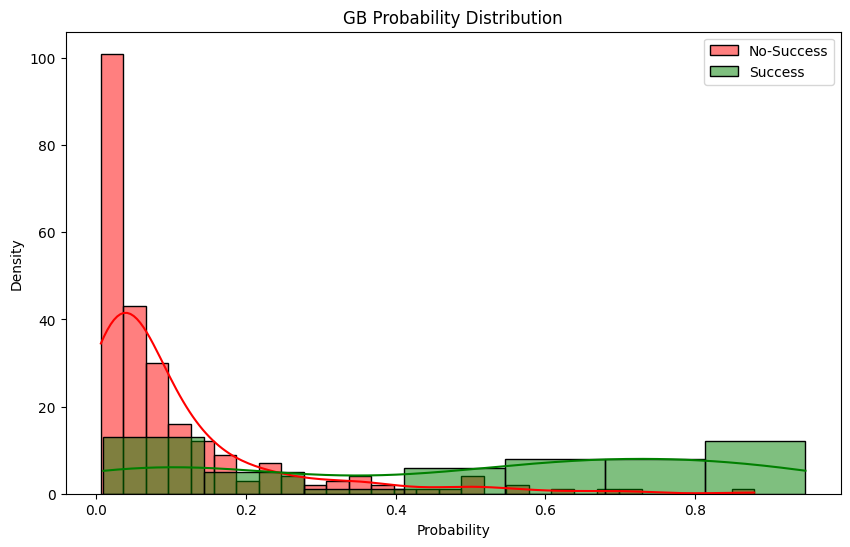

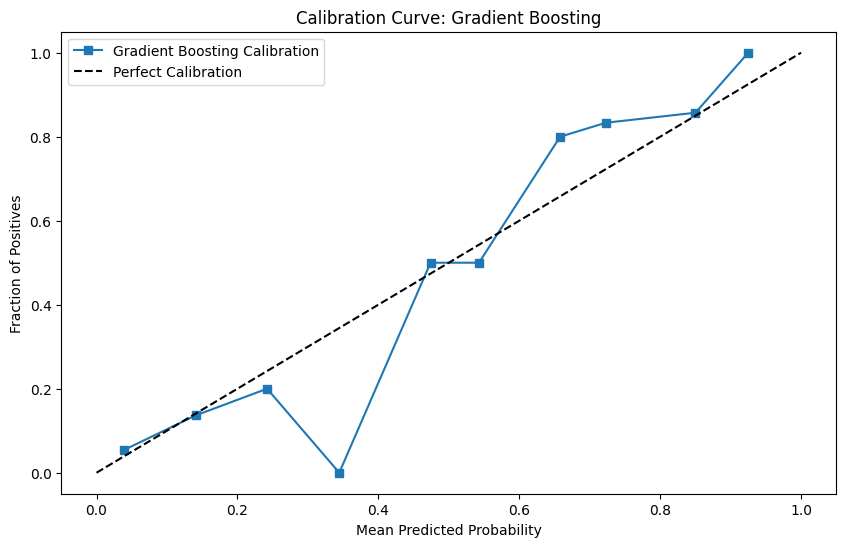

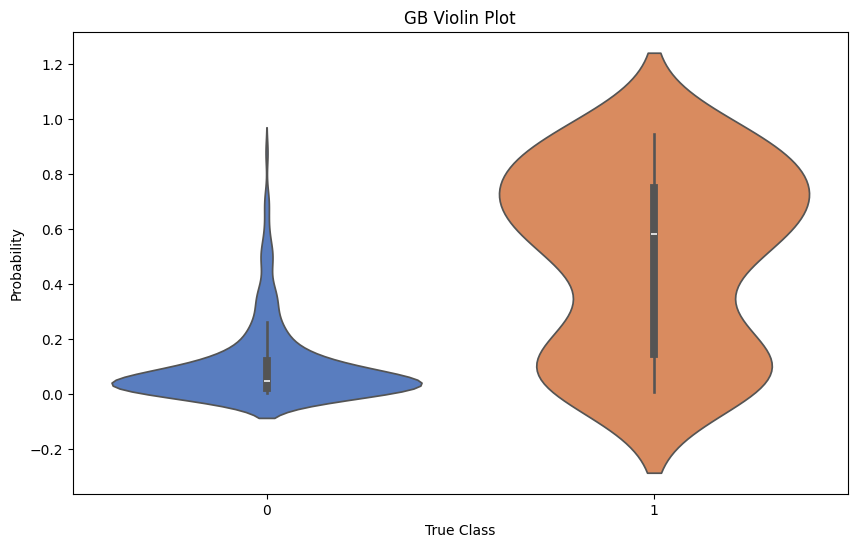

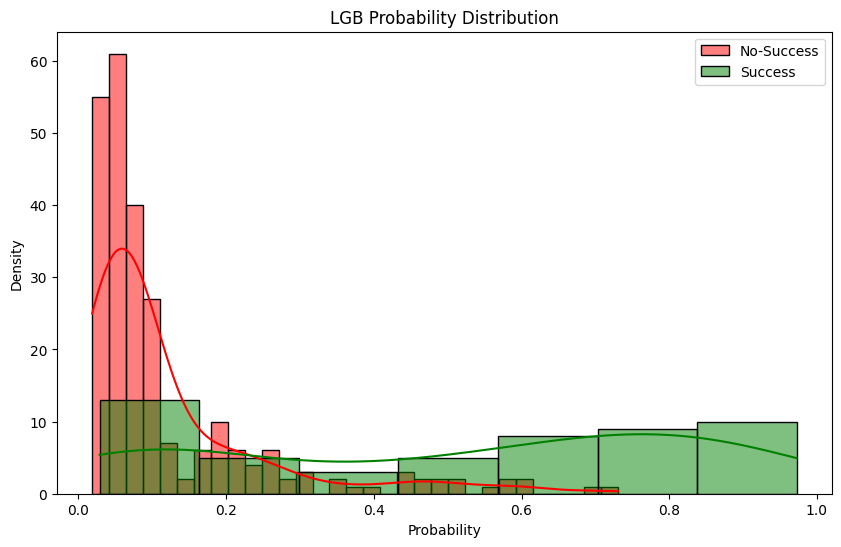

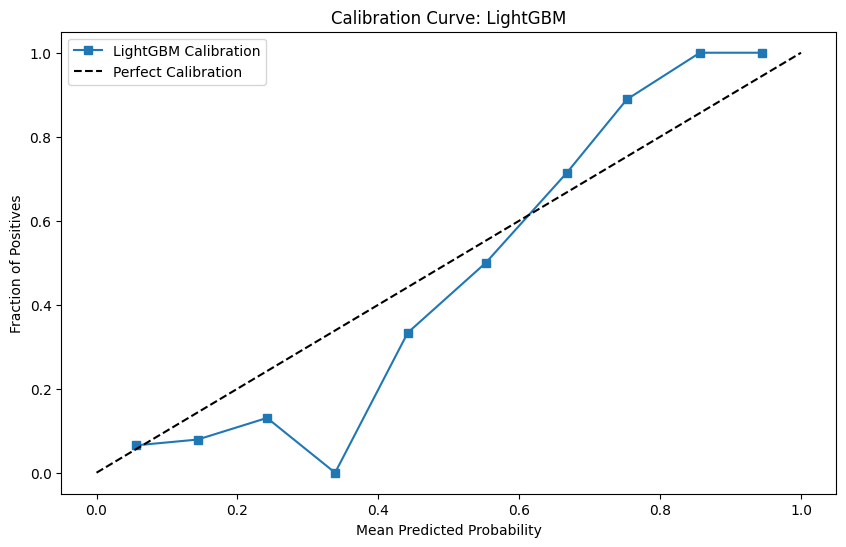

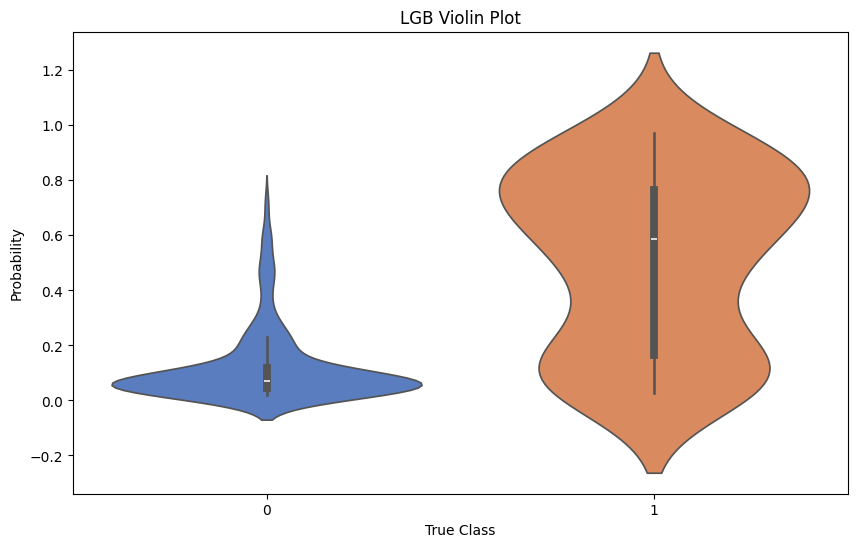

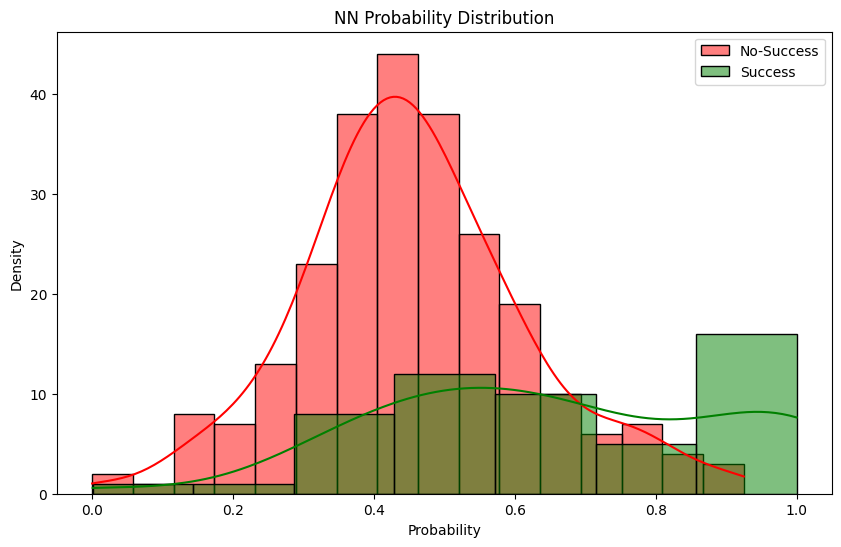

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


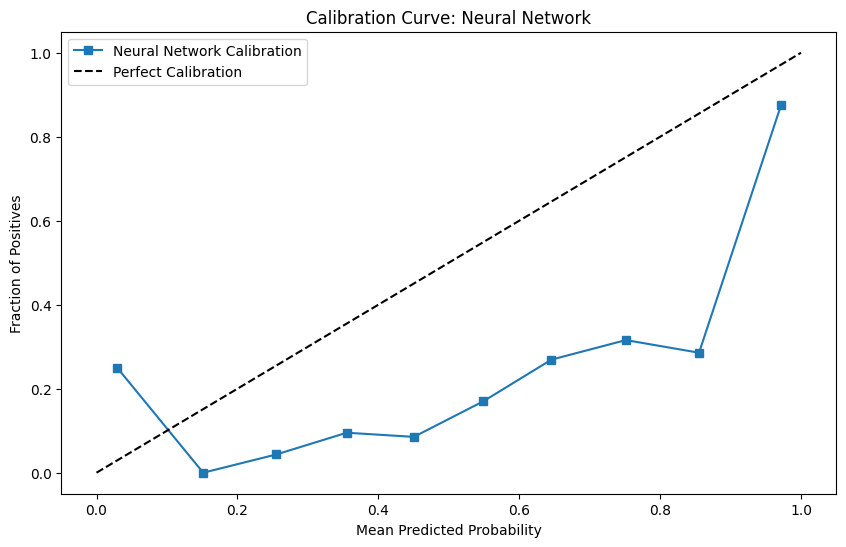

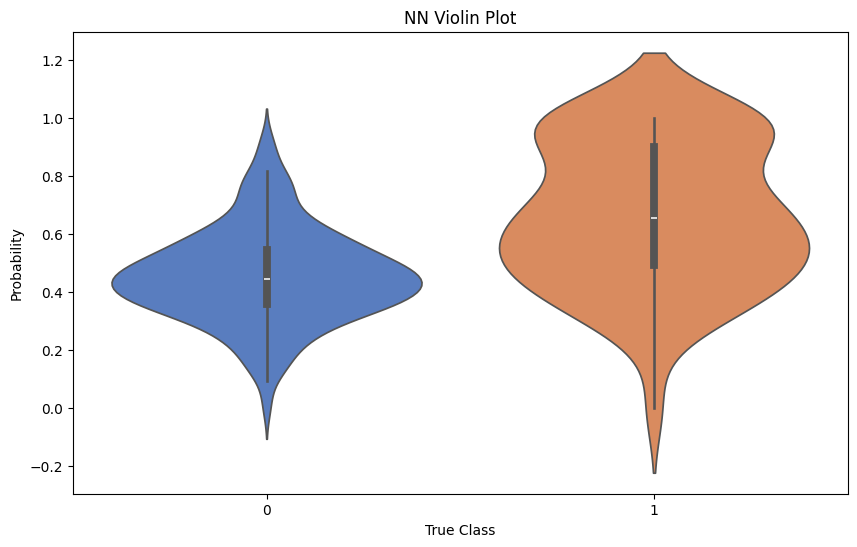

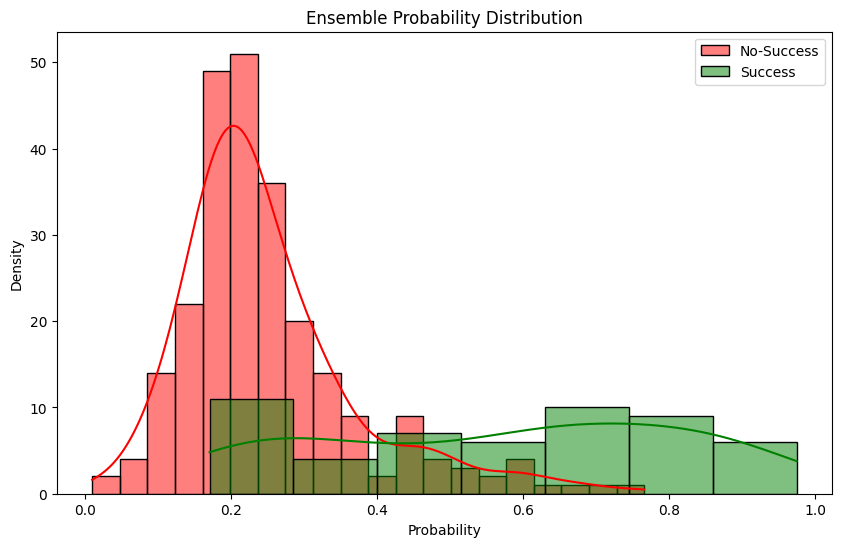

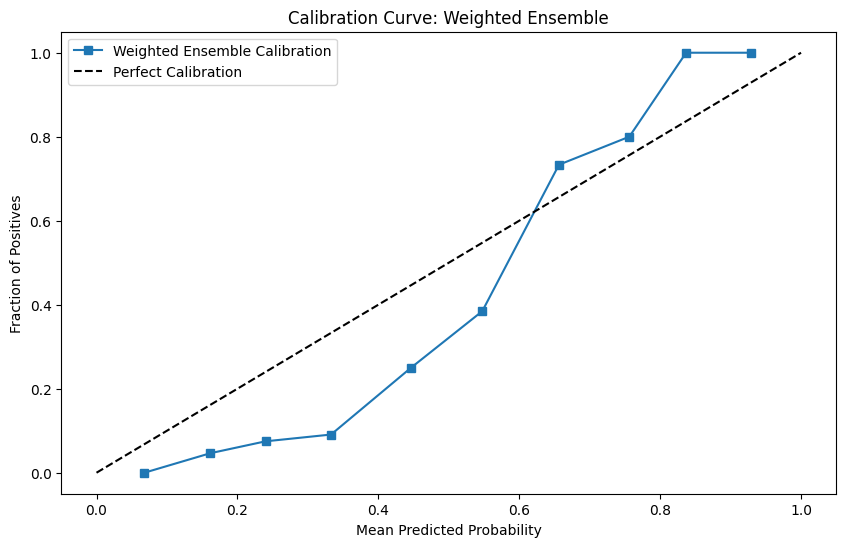

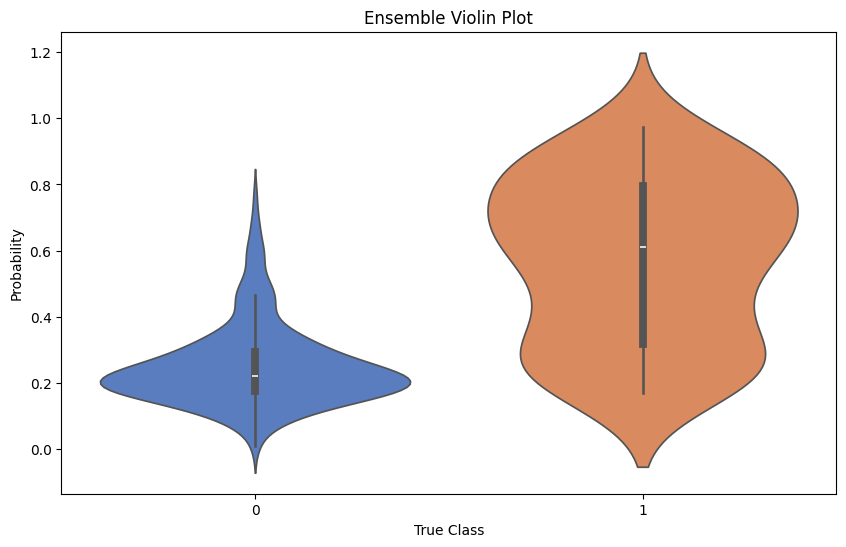

In [44]:
def probability_distribution_plot(df, model_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[df["True Class (Test)"] == 0][f"{model_name} Probability (Success, Test)"], color="red", label="No-Success", kde=True)
    sns.histplot(df[df["True Class (Test)"] == 1][f"{model_name} Probability (Success, Test)"], color="green", label="Success", kde=True)
    plt.title(f"{model_name} Probability Distribution")
    plt.xlabel("Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

def calibration_curve_plot(model, X, y, model_name, is_nn=False, is_ensemble=False):
    if is_nn:
        probs = model.predict(X).ravel()
    elif is_ensemble:
        probs = model  # Directly pass ensemble probabilities
    else:
        probs = model.predict_proba(X)[:, 1]
    prob_true, prob_pred = calibration_curve(y, probs, n_bins=10)
    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, "s-", label=f"{model_name} Calibration")
    plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
    plt.title(f"Calibration Curve: {model_name}")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.show()

# Violin Plot
def violin_plot(df, model_name):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="True Class (Test)", y=f"{model_name} Probability (Success, Test)", data=df, palette="muted")
    plt.title(f"{model_name} Violin Plot")
    plt.xlabel("True Class")
    plt.ylabel("Probability")
    plt.show()

# Gradient Boosting
probability_distribution_plot(test_results, "GB")
calibration_curve_plot(best_gb_model, X_test_scaled, y_test, "Gradient Boosting")
violin_plot(test_results, "GB")

# LightGBM
probability_distribution_plot(test_results, "LGB")
calibration_curve_plot(best_lgb_model, X_test_scaled, y_test, "LightGBM")
violin_plot(test_results, "LGB")

# Neural Network
probability_distribution_plot(test_results, "NN")
calibration_curve_plot(nn_model, X_test_scaled, y_test, "Neural Network", is_nn=True)
violin_plot(test_results, "NN")

# Weighted Ensemble
probability_distribution_plot(test_results, "Ensemble")
calibration_curve_plot(ensemble_test_probabilities, X_test_scaled, y_test, "Weighted Ensemble", is_ensemble=True)
violin_plot(test_results, "Ensemble")


## Feature Importance

### Method 1:

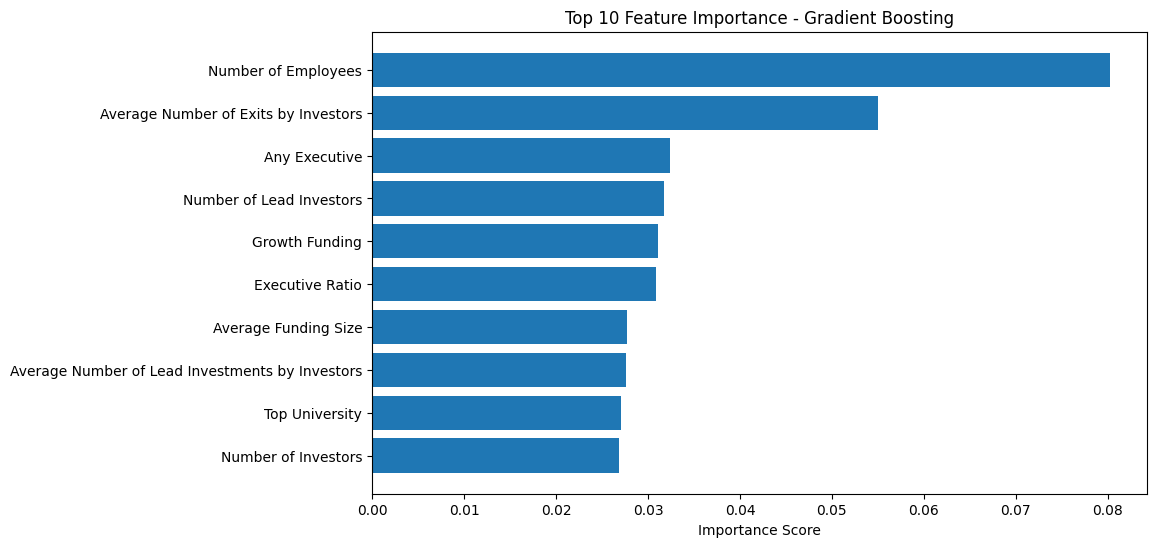

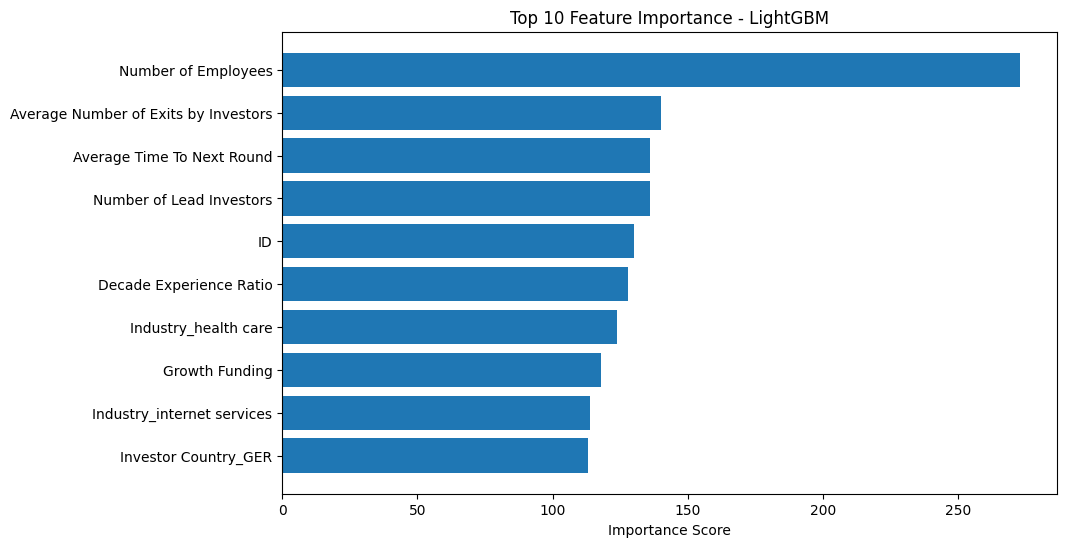

In [45]:
# Feature Importance Visualization (Top 10 Features)
def plot_top_feature_importance(model, feature_names, model_name, top_n=10):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'feature_importance_'):
        importances = model.feature_importance_()
    else:
        print(f"{model_name} does not support feature importance.")
        return

    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.gca().invert_yaxis()
    plt.title(f'Top {top_n} Feature Importance - {model_name}')
    plt.xlabel('Importance Score')
    plt.show()

# Plot top 10 feature importance for each model
feature_names = X.columns
plot_top_feature_importance(best_gb_model, feature_names, "Gradient Boosting")
plot_top_feature_importance(best_lgb_model, feature_names, "LightGBM")

### Method 2: SHAP-values

Analyzing Gradient Boosting Model...
Gradient Boosting SHAP Summary Plot:


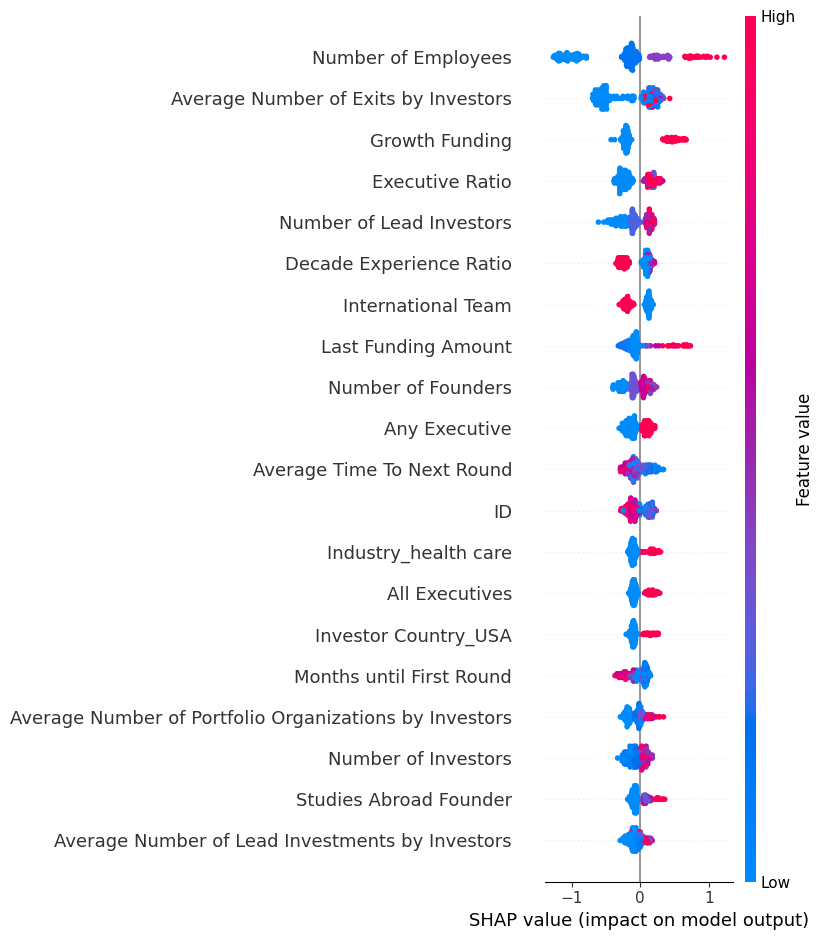

Gradient Boosting SHAP Bar Plot:


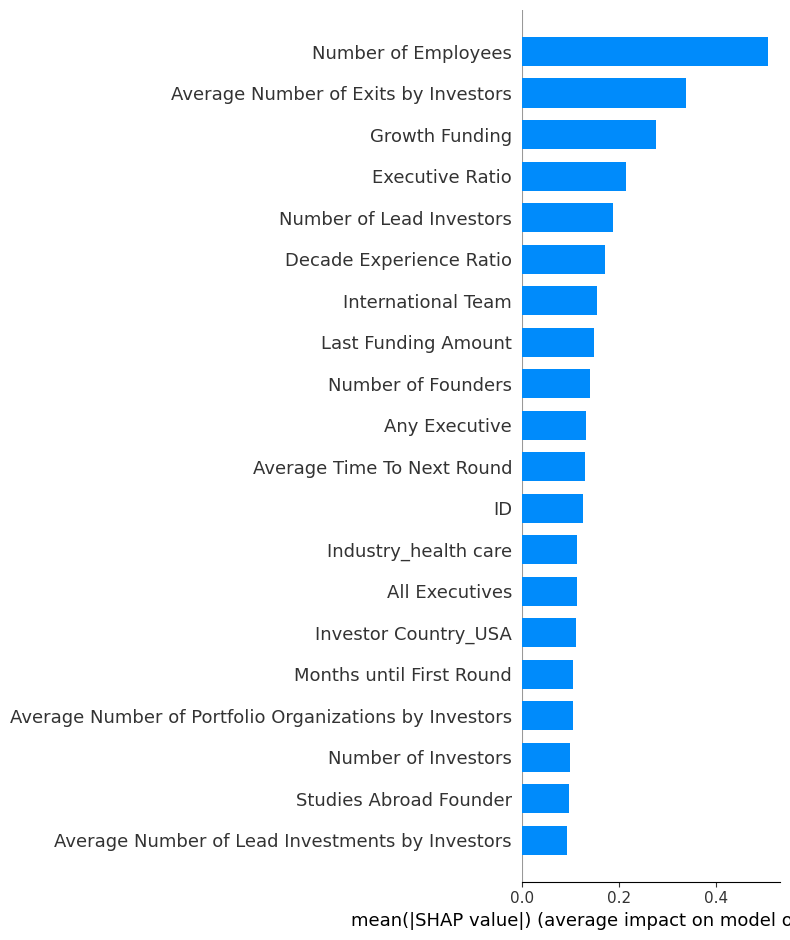

Analyzing LightGBM Model...
LightGBM SHAP Summary Plot:


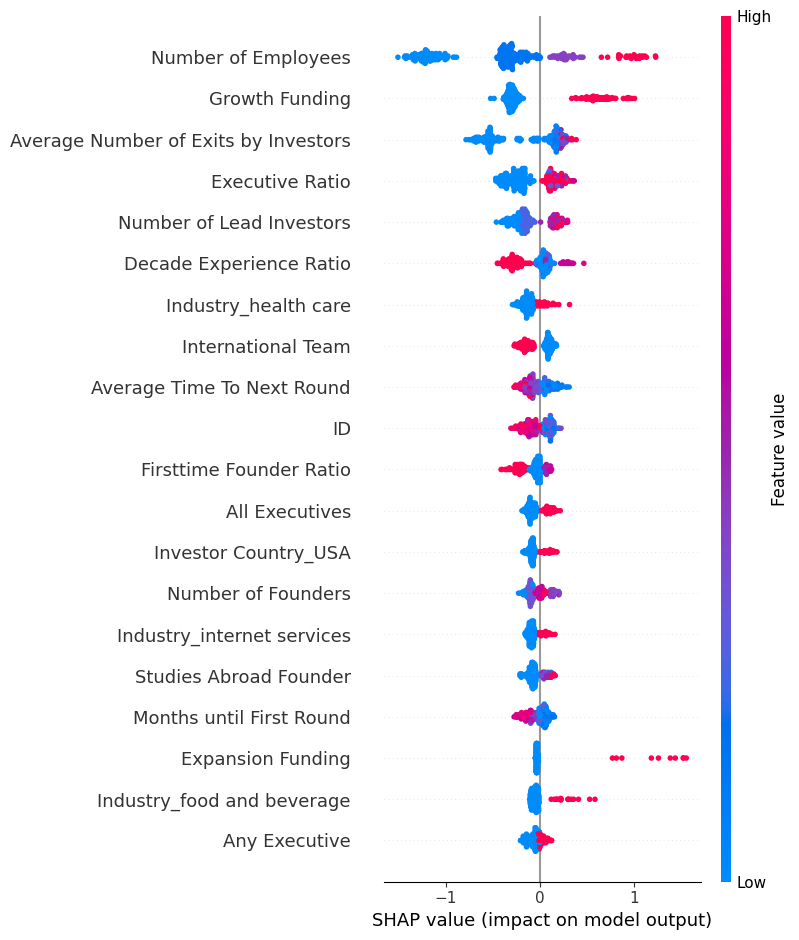

LightGBM SHAP Bar Plot:


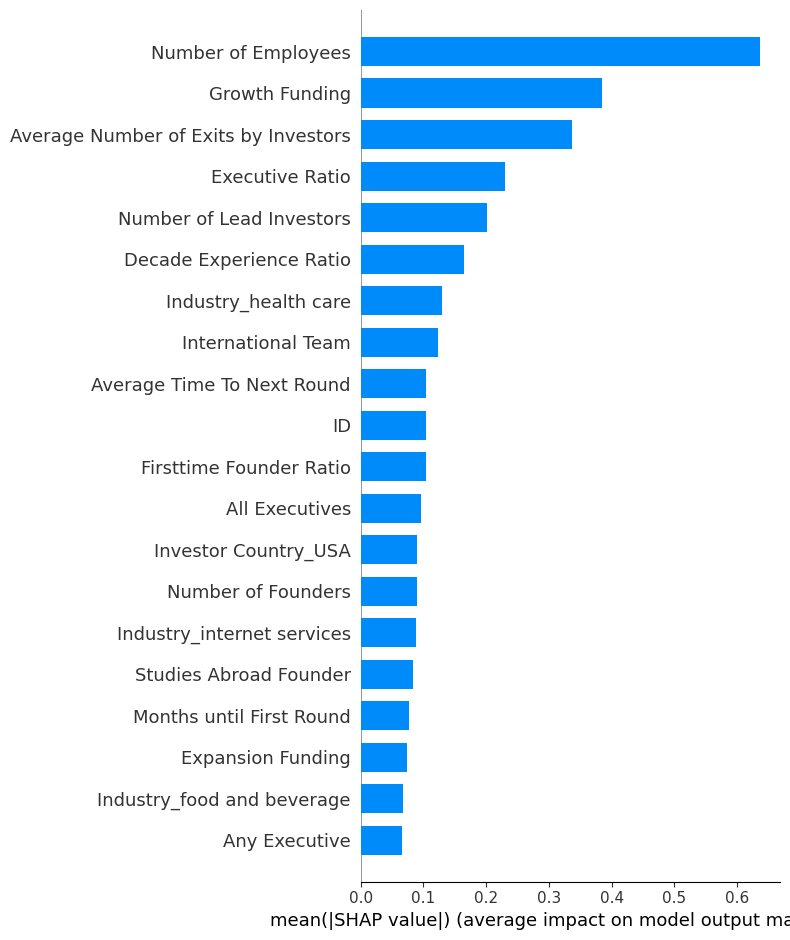

In [46]:
def shap_analysis_gradient_boosting(model, X_train, X_test, feature_names, plot=True):
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        if plot:
            # SHAP Summary Plot
            print("Gradient Boosting SHAP Summary Plot:")
            shap.summary_plot(shap_values, X_test, feature_names=feature_names)

            # SHAP Bar Plot
            print("Gradient Boosting SHAP Bar Plot:")
            shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")

        return shap_values
    except Exception as e:
        print(f"Error in SHAP analysis for Gradient Boosting: {e}")
        return None


def shap_analysis_lightgbm(model, X_train, X_test, feature_names, plot=True):
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        if plot:
            # SHAP Summary Plot
            print("LightGBM SHAP Summary Plot:")
            shap.summary_plot(shap_values, X_test, feature_names=feature_names)

            # SHAP Bar Plot
            print("LightGBM SHAP Bar Plot:")
            shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")

        return shap_values
    except Exception as e:
        print(f"Error in SHAP analysis for LightGBM: {e}")
        return None


# Calculate SHAP values and store them in variables
print("Analyzing Gradient Boosting Model...")
gb_shap_values = shap_analysis_gradient_boosting(best_gb_model, X_train_scaled, X_test_scaled, X.columns, plot=True)

print("Analyzing LightGBM Model...")
lgb_shap_values = shap_analysis_lightgbm(best_lgb_model, X_train_scaled, X_test_scaled, X.columns, plot=True)